Maximum size found: (43, 59, 47)
Epoch [1/200], Train Loss: 0.9851, Val Loss: 0.7787
Epoch [10/200], Train Loss: 0.6811, Val Loss: 0.6918
Epoch [20/200], Train Loss: 0.5589, Val Loss: 0.5984
Epoch [30/200], Train Loss: 0.4649, Val Loss: 0.5201
Epoch [40/200], Train Loss: 0.3916, Val Loss: 0.4404
Epoch [50/200], Train Loss: 0.3338, Val Loss: 0.3966
Epoch [60/200], Train Loss: 0.2839, Val Loss: 0.3529
Epoch [70/200], Train Loss: 0.2431, Val Loss: 0.3060
Epoch [80/200], Train Loss: 0.2082, Val Loss: 0.2661
Epoch [90/200], Train Loss: 0.1814, Val Loss: 0.2691
Epoch [100/200], Train Loss: 0.1550, Val Loss: 0.2343
Model saved at epoch 100.
Epoch [110/200], Train Loss: 0.1343, Val Loss: 0.2585
Epoch [120/200], Train Loss: 0.1178, Val Loss: 0.1976
Epoch [130/200], Train Loss: 0.1016, Val Loss: 0.2283
Epoch [140/200], Train Loss: 0.0906, Val Loss: 0.1860
Epoch [150/200], Train Loss: 0.0797, Val Loss: 0.2041
Epoch [160/200], Train Loss: 0.0697, Val Loss: 0.1671
Epoch [170/200], Train Loss: 0.060

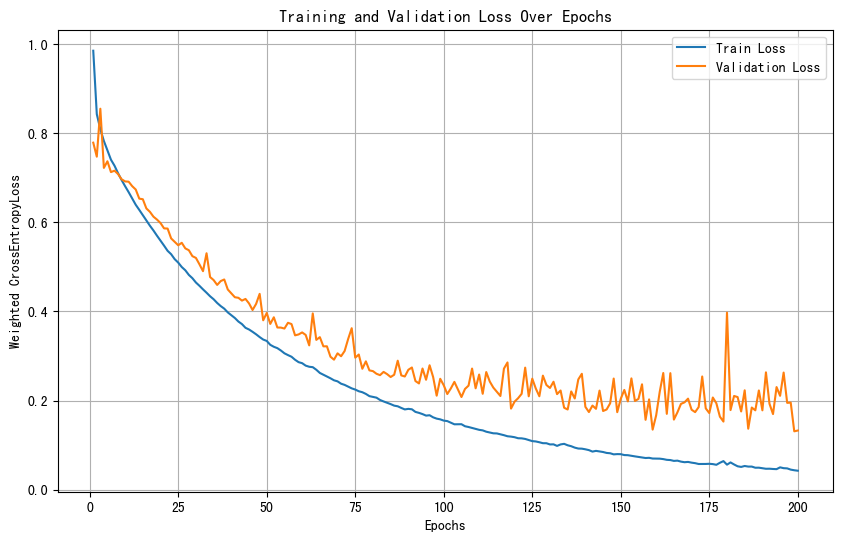

In [5]:
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pathlib import Path
import os
import matplotlib.pyplot as plt


# Due to inconsistent image sizes, choose the largest size as the target size and pad the rest with zeros.
def find_max_size(image_dir):
    image_paths = sorted(Path(image_dir).glob('*.nii.gz'))
    max_size = (0, 0, 0)
    for img_path in image_paths:
        img = nib.load(img_path).get_fdata()
        max_size = tuple(max(s, m) for s, m in zip(img.shape, max_size))
    print(f"Maximum size found: {max_size}")
    return max_size

def center_crop_or_pad(image, target_size):
    current_size = image.shape
    result = np.zeros(target_size, dtype=image.dtype)
    startZ = max(0, (current_size[0] - target_size[0]) // 2)
    startY = max(0, (current_size[1] - target_size[1]) // 2)
    startX = max(0, (current_size[2] - target_size[2]) // 2)
    endZ = min(current_size[0], startZ + target_size[0])
    endY = min(current_size[1], startY + target_size[1])
    endX = min(current_size[2], startX + target_size[2])
    source_slice = tuple(slice(start, end) for start, end in zip([startZ, startY, startX], [endZ, endY, endX]))
    target_slice = tuple(slice(max(0, -start), min(sz, ts - start))
                         for sz, ts, start in zip(current_size, target_size, [startZ, startY, startX]))
    source_data = image[source_slice]

    # If the current size is larger than the target size, then perform cropping; otherwise, perform padding.
    if all(cs >= ts for cs, ts in zip(current_size, target_size)):
        result = source_data
    else:
        result[target_slice] = source_data
    return result


class MedicalImageDataset(Dataset):
    def __init__(self, image_paths, label_paths, target_size, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.target_size = target_size
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        img = nib.load(img_path).get_fdata()
        label = nib.load(label_path).get_fdata()
        img = img.astype(np.float32)
        label = label.astype(np.int64)
        if self.transform:
            img = self.transform(img)
            label = self.transform(label)
        img = center_crop_or_pad(img, self.target_size)
        label = center_crop_or_pad(label, self.target_size)
        img = np.expand_dims(img, axis=0)
        return torch.from_numpy(img), torch.from_numpy(label)


image_dir = 'train/img'
label_dir = 'train/label'
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.nii.gz')])
label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.nii.gz')])


max_size = find_max_size(image_dir)
train_image_files, val_image_files, train_label_files, val_label_files = train_test_split(
    image_files, label_files, test_size=0.2, random_state=42)
train_dataset = MedicalImageDataset(train_image_files, train_label_files, target_size=max_size)
val_dataset = MedicalImageDataset(val_image_files, val_label_files, target_size=max_size)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)


#Vnet
def passthrough(x, **kwargs):
    return x

def ELUCons(elu, nchan):
    if elu:
        return nn.ELU(inplace=True)
    else:
        return nn.PReLU(nchan)

class ContBatchNorm3d(nn.modules.batchnorm._BatchNorm):
    def _check_input_dim(self, input):
        if input.dim() != 5:
            raise ValueError('expected 5D input (got {}D input)'
                             .format(input.dim()))

    def forward(self, input):
        self._check_input_dim(input)
        return F.batch_norm(
            input, self.running_mean, self.running_var, self.weight, self.bias,
            self.training, self.momentum, self.eps)

class LUConv(nn.Module):
    def __init__(self, nchan, elu):
        super(LUConv, self).__init__()
        self.relu1 = ELUCons(elu, nchan)
        self.conv1 = nn.Conv3d(nchan, nchan, kernel_size=5, padding=2)
        self.bn1 = ContBatchNorm3d(nchan)

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        return out

def _make_nConv(nchan, depth, elu):
    layers = []
    for _ in range(depth):
        layers.append(LUConv(nchan, elu))
    return nn.Sequential(*layers)

class InputTransition(nn.Module):
    def __init__(self, outChans, elu):
        super(InputTransition, self).__init__()
        self.conv1 = nn.Conv3d(1, outChans, kernel_size=5, padding=2)
        self.bn1 = ContBatchNorm3d(outChans)
        self.relu1 = ELUCons(elu, outChans)
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        return out

class DownTransition(nn.Module):
    def __init__(self, inChans, nConvs, elu, dropout=False):
        super(DownTransition, self).__init__()
        outChans = 2 * inChans
        self.down_conv = nn.Conv3d(inChans, outChans, kernel_size=2, stride=2)
        self.bn1 = ContBatchNorm3d(outChans)
        self.do1 = passthrough
        self.relu1 = ELUCons(elu, outChans)
        self.relu2 = ELUCons(elu, outChans)
        if dropout:
            self.do1 = nn.Dropout3d()
        self.ops = _make_nConv(outChans, nConvs, elu)
    def forward(self, x):
        down = self.relu1(self.bn1(self.down_conv(x)))
        out = self.do1(down)
        out = self.ops(out)
        out = self.relu2(out + down)
        return out

class UpTransition(nn.Module):
    def __init__(self, inChans, outChans, nConvs, elu, dropout=False):
        super(UpTransition, self).__init__()
        self.up_conv = nn.ConvTranspose3d(inChans, outChans // 2, kernel_size=2, stride=2)
        self.bn1 = ContBatchNorm3d(outChans // 2)
        self.do1 = passthrough
        self.do2 = nn.Dropout3d()
        self.relu1 = ELUCons(elu, outChans // 2)
        self.relu2 = ELUCons(elu, outChans)
        if dropout:
            self.do1 = nn.Dropout3d()
        self.ops = _make_nConv(outChans, nConvs, elu)

    def forward(self, x, skipx):
        out = self.do1(x)
        skipxdo = self.do2(skipx)
        out = self.relu1(self.bn1(self.up_conv(out)))
        diffZ = skipxdo.size()[2] - out.size()[2]
        diffY = skipxdo.size()[3] - out.size()[3]
        diffX = skipxdo.size()[4] - out.size()[4]
        if diffZ != 0 or diffY != 0 or diffX != 0:
            out = F.pad(out, [diffX // 2, diffX - diffX // 2,
                              diffY // 2, diffY - diffY // 2,
                              diffZ // 2, diffZ - diffZ // 2])
        xcat = torch.cat((out, skipxdo), 1)
        out = self.ops(xcat)
        out = self.relu2(out + xcat)
        return out

class OutputTransition(nn.Module):
    def __init__(self, inChans, elu, nll, num_classes=3):
        super(OutputTransition, self).__init__()
        self.conv1 = nn.Conv3d(inChans, num_classes, kernel_size=5, padding=2)
        self.bn1 = ContBatchNorm3d(num_classes)
        self.relu1 = ELUCons(elu, num_classes)
        if nll:
            self.softmax = F.log_softmax
        else:
            self.softmax = F.softmax

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        return out


class VNet(nn.Module):
    def __init__(self, elu=True, nll=False, num_classes=3):
        super(VNet, self).__init__()
        self.in_tr = InputTransition(16, elu)
        self.down_tr32 = DownTransition(16, 1, elu)
        self.down_tr64 = DownTransition(32, 2, elu)
        self.down_tr128 = DownTransition(64, 3, elu, dropout=True)
        self.down_tr256 = DownTransition(128, 2, elu, dropout=True)
        self.up_tr256 = UpTransition(256, 256, 2, elu, dropout=True)
        self.up_tr128 = UpTransition(256, 128, 2, elu, dropout=True)
        self.up_tr64 = UpTransition(128, 64, 1, elu)
        self.up_tr32 = UpTransition(64, 32, 1, elu)
        self.out_tr = OutputTransition(32, elu, nll, num_classes)

    def forward(self, x):
        out16 = self.in_tr(x)
        out32 = self.down_tr32(out16)
        out64 = self.down_tr64(out32)
        out128 = self.down_tr128(out64)
        out256 = self.down_tr256(out128)
        out = self.up_tr256(out256, out128)
        out = self.up_tr128(out, out64)
        out = self.up_tr64(out, out32)
        out = self.up_tr32(out, out16)
        out = self.out_tr(out)
        return out


model = VNet(num_classes=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Set the weighted cross-entropy loss function
weights = torch.tensor([0.09, 0.46, 0.45]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.0002)


save_dir = '2025'
os.makedirs(save_dir, exist_ok=True)
num_epochs = 200
save_interval = 100
display_interval = 10
best_val_loss = float('inf')

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    if (epoch + 1) % display_interval == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = os.path.join(save_dir, 'best_model.pth')
        torch.save(model.state_dict(), best_model_path)

    if (epoch + 1) % save_interval == 0:
        interval_model_path = os.path.join(save_dir, f'model_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), interval_model_path)
        print(f"Model saved at epoch {epoch+1}.")

print("Training complete.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Weighted CrossEntropyLoss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'loss_plot.png'))
plt.show()